# Using a different solver

The steps taken in the [first notebook](TV_denoising_with_PDHG.ipynb) are largely the same for all solvers. However, the specific form

$$
    \min_{x \in X} \left[ f(L x) + g(x) \right]
$$

required us to rewrite the problem using product spaces.

Other optimization methods, such as the (primal-dual variants of the) [Forward-Backward](https://github.com/odlgroup/odl/blob/master/odl/solvers/nonsmooth/forward_backward.py) [BC2015] and [Douglas-Rachford](https://github.com/odlgroup/odl/blob/master/odl/solvers/nonsmooth/douglas_rachford.py) [BH2013] methods, provide alternatives to PDHG that can be easier to set up.

## The Douglas-Rachford solver

We will take a closer look at the Douglas-Rachford splitting based method. Without going into the mathematical details of why and how, we observe that this method can solve problems of the form

$$
    \min_{x \in X} \left[ f(x) + \sum_{i=1}^n g_i (L_i x) \right]
$$

with convex functions $f$, $g_1, \dots, g_n$ and linear operators $L_1, \dots, L_n$. So in contrast to the PDHG method, we may have *any number of functions composed with linear operators*, which makes it much easier to set up the problem.

## Setting up the problem

We consider again the TV denoising problem

$$
    \min_{x \geq 0} \left[\| x - y \|_2^2 + \alpha \| \nabla x \|_1 \right],
$$

or, rewriting the positivity constraint,

$$
    \min_x \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 + \iota_0(x) \right].
$$

This form is already in the right shape for our solver, since we can choose the functions

$$
    f = \iota_0,\quad g_1 = \|\cdot - y\|_2^2, \quad g_2 = \|\cdot\|_1,
$$

and the linear operators

$$
    L_1 = I, \quad L_2 = \nabla.
$$

## Parameter selection

In exchange for the easy problem setup, we somewhat trade the simplicity of finding good optimization parameters. The Douglas-Rachford method is guaranteed to converge if $\tau$ and $\sigma_1, \dots, \sigma_n$ are chosen such that

$$
    \tau \sum_{i=1}^n \sigma_i \|L_i\|^2 < 4.
$$

In our case, we have three parameters $\tau, \sigma_1, \sigma_2$, which makes it a bit more complicated to pick good values compared to PDHG with two parameters. As a rule of thumb, it often makes sense to have the $\sigma_i$ parameters balance the operator norms, i.e., to choose

$$
    \sigma_i = c \|L_i\|^{-2},
$$

and to select $\tau$ such that the sum converges, i.e.,

$$
    \tau < \frac{4}{nc}.
$$

It also makes sense to push the keep the sum in the order of 1 since otherwise, the step sizes are too small. Overall selecting good parameters is a bit of a trial-and-error procedure.

## Implementation

We consider the same scenario as in the [first notebook](TV_denoising_with_PDHG.ipynb). As before, we define a reconstruction space $X$ using uniform sampling on the rectangle $[0, N]$

/tmp/ipykernel_459/3381430676.py:8: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  image = scipy.misc.ascent().astype('float32')


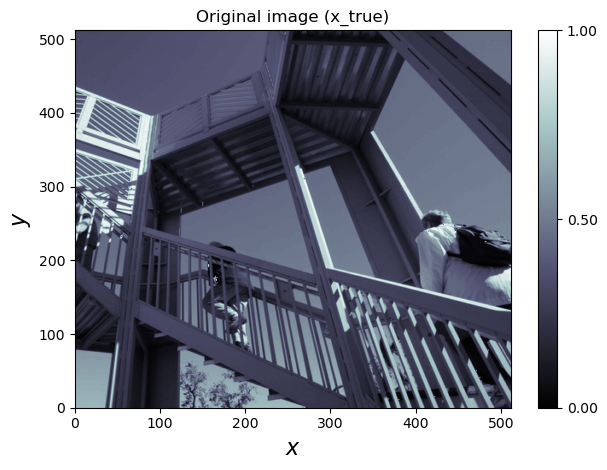

<Figure size 640x480 with 0 Axes>

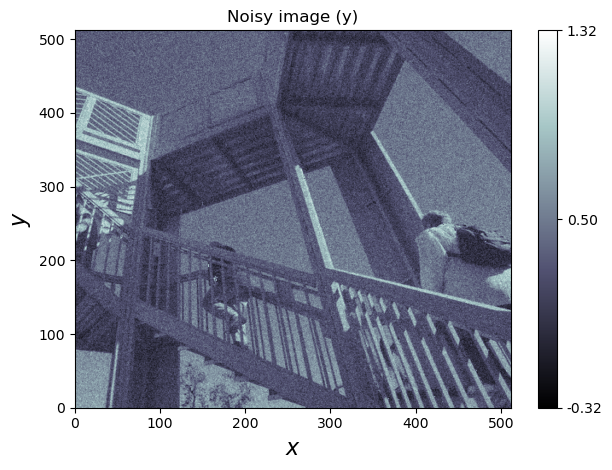

<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
import numpy as np
import scipy.misc

import odl

# Generate test image
image = scipy.misc.ascent().astype('float32')

# Create reconstruction space
shape = image.T.shape
X = odl.uniform_discr(min_pt=[0, 0], max_pt=shape, shape=shape)

# Wrap image as space element, generate noisy variant and display
image /= image.max()
x_true = X.element(np.rot90(image, -1))
# To get predictable randomness, we explicitly seed the random number generator
#with odl.util.NumpyRandomSeed(123):
np.random.seed(123)
y = x_true + 0.1 * odl.phantom.white_noise(X)
    
x_true.show(title='Original image (x_true)');
y.show(title='Noisy image (y)');

Now we set up the functions and the linear operators:

$$
    f = \iota_0,\quad g_1 = \|\cdot - y\|_2^2, \quad g_2 = \|\cdot\|_1, \\
    L_1 = I, \quad L_2 = \nabla.
$$

In [2]:
ident = odl.IdentityOperator(X)
grad = odl.Gradient(X)  # need this here for L1Norm below

# Function without linear operator
f = odl.solvers.IndicatorNonnegativity(X)

# Functions to be composed with linear operators. L[i] applies to g[i].
alpha = 0.15
g = [odl.solvers.L2NormSquared(X).translated(y),
     alpha * odl.solvers.L1Norm(grad.range)]
L = [ident, grad]

# We check if everything makes sense by evaluating the total functional at 0
x = X.zero()
print(f(x) + sum(g[i](L[i](x)) for i in range(len(g))))

43091.26862759991


Now we set the $\tau$ and $\sigma_i$ parameters for the optimization. We use a small function to make it easier to check if the parameters work. To make the parameter search space smaller, we choose $\tau$ (primal step size) and select

$$
    \sigma_i = \frac{c}{\|L_i\|^2}, \quad c = \frac{3}{n \tau}
$$

with $n = 2$ in our case.

In [3]:
grad_norm = 1.1 * odl.power_method_opnorm(grad, xstart=y, maxiter=20)
opnorms = [1, grad_norm]  # identity has norm 1


def check_params(tau, sigmas):
    sum_part = sum(sigma * opnorm ** 2
                   for sigma, opnorm in zip(sigmas, opnorms))
    print('Sum evaluates to', sum_part)
    check_value = tau * sum_part
    
    assert check_value < 4, 'value must be < 4, got {}'.format(check_value)
    print('Values ok, check evaluates to {}, must be < 4'.format(check_value))
    

tau = 1.5
c = 3.0 / (len(opnorms) * tau)
sigmas = [c / opnorm ** 2 for opnorm in opnorms]
check_params(tau, sigmas)

Sum evaluates to 2.0
Values ok, check evaluates to 3.0, must be < 4


Now we're ready to run the solver!

In [4]:
?odl.solvers.douglas_rachford_pd


Signature:
odl.solvers.douglas_rachford_pd(
    x,
    f,
    g,
    L,
    niter,
    tau=None,
    sigma=None,
    callback=None,
    **kwargs,
)
Docstring:
Douglas-Rachford primal-dual splitting algorithm.

Minimizes the sum of several convex functions composed with linear
operators::

    min_x f(x) + sum_i g_i(L_i x)

where ``f``, ``g_i`` are convex functions, ``L_i`` are linear `Operator`'s.

Can also be used to solve the more general problem::

    min_x f(x) + sum_i (g_i @ l_i)(L_i x)

where ``l_i`` are convex functions and ``@`` is the infimal convolution::

    (g @ l)(x) = inf_y g(y) + l(x - y)

For references on the algorithm, see algorithm 3.1 in [BH2013].

Parameters
----------
x : `LinearSpaceElement`
    Initial point, updated in-place.
f : `Functional`
    `proximal factory` for the function ``f``.
g : sequence of `Functional`'s
    Sequence of of the functions ``g_i``. Needs to have
    ``g[i].convex_conj.proximal``.
L : sequence of `Operator`'s
    Sequence of `Opera

In [5]:
# Starting point
x = X.zero()

# Run PDHG method. The vector `x` is updated in-place.
odl.solvers.douglas_rachford_pd(x, f, g, L, tau=tau, sigma=sigmas, niter=200)

We again visually inspect the results and evaluate some quality metrics from `odl.contrib.fom`:

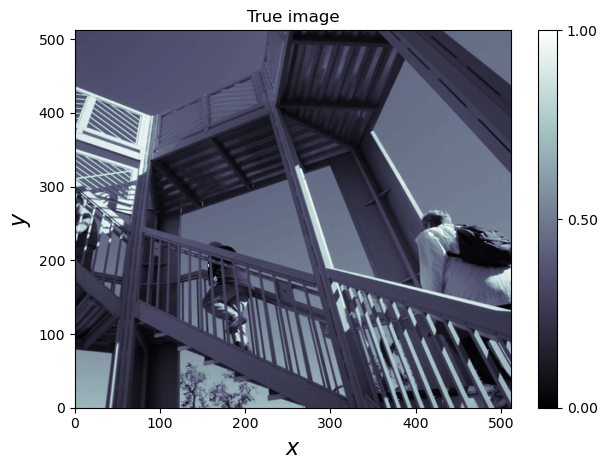

<Figure size 640x480 with 0 Axes>

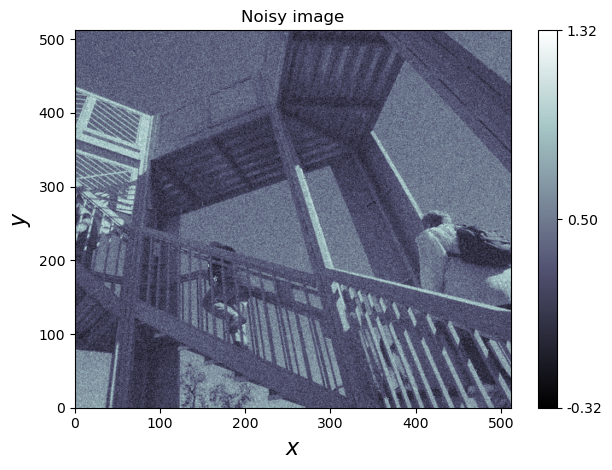

<Figure size 640x480 with 0 Axes>

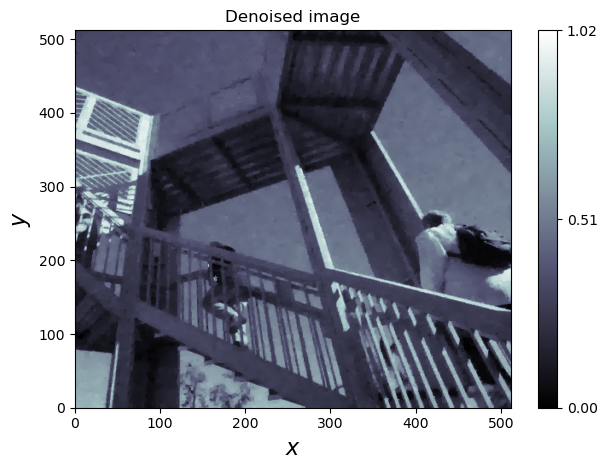

<Figure size 640x480 with 0 Axes>

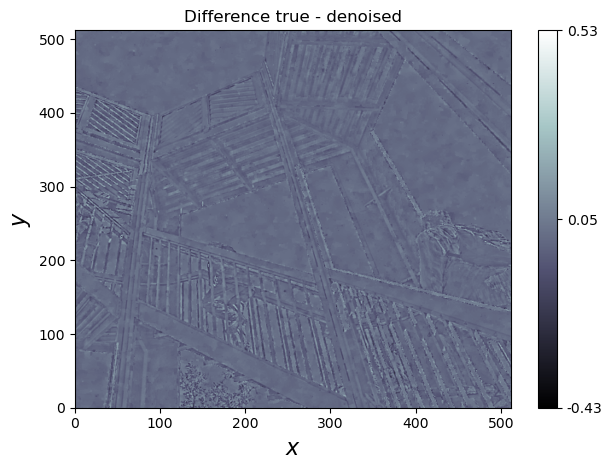

<Figure size 640x480 with 0 Axes>

In [6]:
x_true.show('True image');
y.show('Noisy image');
x.show('Denoised image');
(x_true - x).show('Difference true - denoised');

In [7]:
from odl.contrib import fom

print('Noisy')
print('-----')
print('Mean squared error:', fom.mean_squared_error(y, x_true))
print('PSNR:', fom.psnr(y, x_true))
print('SSIM:', fom.ssim(y, x_true))
print('')

print('Denoised')
print('--------')
print('Mean squared error:', fom.mean_squared_error(x, x_true))
print('PSNR:', fom.psnr(x, x_true))
print('SSIM:', fom.ssim(x, x_true))

Noisy
-----
Mean squared error: 0.00996207815233
PSNR: 20.0165005556
SSIM: 0.338040264996

Denoised
--------
Mean squared error: 0.00161224923869
PSNR: 27.9256781947
SSIM: 0.846093773756


## References

[BC2015] Bot, R I, and Csetnek, E R. *On the convergence rate of a forward-backward type primal-dual splitting algorithm for convex optimization problems*. Optimization, 64.1 (2015), pp 5--23.

[BH2013] Bot, R I, and Hendrich, C. *A Douglas-Rachford type primal-dual method for solving inclusions with mixtures of     composite and parallel-sum type monotone operators*. SIAM Journal on Optimization, 23.4 (2013), pp 2541--2565.